<a href="https://colab.research.google.com/github/Tim1l/goldtrendprediction/blob/main/goldtrendprediction_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Gold trend prediction
# Target - to predict next 1h moving

In [1]:
!pip install keras-tcn
!pip install keras-tcn --no-dependencies
!pip install --upgrade mplfinance
import mplfinance as mpf
import pandas as pd 
import matplotlib.pyplot as plt 
from tensorflow.keras import utils
import numpy as np 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, TimeDistributed, Bidirectional, MaxPooling1D, BatchNormalization, Flatten, Conv1D, Conv2D, RepeatVector, LSTM, GlobalMaxPooling1D, LeakyReLU, ConvLSTM2D 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 
from datetime import date 
from keras import callbacks
import math, decimal, datetime
from tensorflow.keras.utils import to_categorical
from tcn import TCN, tcn_full_summary
import mplfinance as mpf

%matplotlib inline

     |████████████████████████████████| 1.1 MB 5.3 MB/s 
     |████████████████████████████████| 64 kB 1.9 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load and process gold and btc charts, 1 hour timeframe for approximately last 10 years

In [3]:
data1 = pd.read_csv('/content/drive/MyDrive/Neuro/Базы/fx net/qualitydata/parsed/gc1h.csv', index_col='DateTime')      #gold1h
data1.index = pd.to_datetime(data1.index, dayfirst=True) 
data1.head()

,Open,High,Low,Close,Volume
DateTime,,,,,
2007-04-01 18:00:00,670.4,671.7,670.1,671.5,320
2007-04-01 19:00:00,671.6,671.7,669.8,670.0,581
2007-04-01 20:00:00,670.1,670.5,669.8,670.5,413
2007-04-01 21:00:00,670.5,670.6,669.7,670.1,113
2007-04-01 22:00:00,670.2,670.2,669.6,670.2,141


In [4]:
data2 = pd.read_csv('/content/drive/MyDrive/Neuro/Базы/fx net/qualitydata/parsed/btcusd1h.csv', index_col='DateTime')  #btc1h
data2.index = pd.to_datetime(data2.index, dayfirst=True) 
data2.head()

,Open,High,Low,Close,Volume
DateTime,,,,,
2011-12-31 08:00:00,4.39,4.39,4.39,4.39,27.334852
2011-12-31 09:00:00,4.39,4.39,4.39,4.39,27.334852
2011-12-31 10:00:00,4.39,4.39,4.39,4.39,27.334852
2011-12-31 11:00:00,4.39,4.39,4.39,4.39,27.334852
2011-12-31 12:00:00,4.39,4.39,4.39,4.39,27.334852


/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:45: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  category=UserWarning)


<Figure size 1872x1296 with 0 Axes>

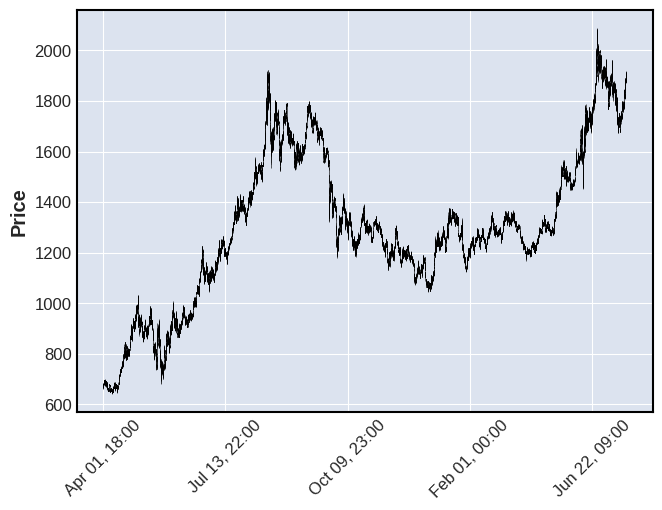

In [5]:
#draw gold chart
plt.figure(figsize=(26,18))
mpf.plot(data1,type='candle')
plt.style.use('fivethirtyeight')   

/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:45: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  category=UserWarning)


<Figure size 2600x1800 with 0 Axes>

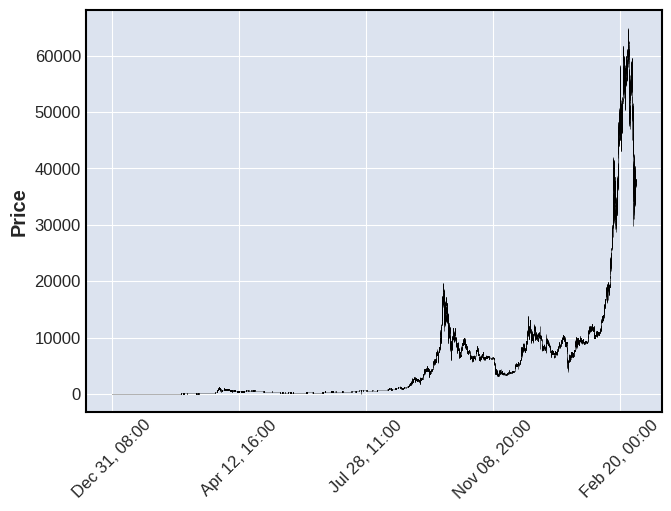

In [57]:
#draw btc chart
plt.figure(figsize=(26,18))
mpf.plot(data2,type='candle')
plt.style.use('fivethirtyeight')   

process gold 1 hour chart

In [7]:
#enriching the dataframe with data
newdf = data1.copy()
col = newdf.columns #get columns names
print(col) #Выводим
#We go through the indexes of the array with column names 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME', 
#get pairs 'OPEN' & 'MAX', 'OPEN'&'MIN', 'OPEN'&'CLOSE' ..., 'MAX'&'MIN', 'MAX'&'CLOSE'&т.д
for i in range(col.shape[0]):                                                   #for all 
  for j in range(i + 1 , col.shape[0]):                                         #count
    newdf[col[i] + '-' + col[j]] = newdf[col[i]] - newdf[col[j]]                   #difference
    newdf['|' + col[i] + '-' + col[j] + '|'] = abs(newdf[col[i]] - newdf[col[j]])  #the modules of difference
    newdf[col[i] + '*' + col[j]] = newdf[col[i]] * newdf[col[j]]                   #multiply

#for every column 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME':
for i in col:
  newdf['reverse ' + i] = 1 / (newdf[i] + 1e-3)
  newdf['derivative ' + i] = np.nan 
  newdf['derivative ' + i][1:] = newdf[i][1:].reset_index(drop=True) - newdf[i][:-1].reset_index(drop=True)
  newdf['second derivative ' + i] = np.nan 
  newdf['second derivative ' + i][2:] = newdf[i][2:].reset_index(drop=True) - 2 * newdf[i][1:-1].reset_index(drop=True) + newdf[i][:-2].reset_index(drop=True) 

newdf = newdf.drop(columns=['Open-Volume','|Open-Volume|','Open*Volume','High-Volume','|High-Volume|','High*Volume','Low-Volume','|Low-Volume|','Low*Volume','Close-Volume','|Close-Volume|','Close*Volume'])

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
newdf.head()

,Open,High,Low,Close,Volume,Open-High,|Open-High|,Open*High,Open-Low,|Open-Low|,Open*Low,Open-Close,|Open-Close|,Open*Close,High-Low,|High-Low|,High*Low,High-Close,|High-Close|,High*Close,Low-Close,|Low-Close|,Low*Close,reverse Open,derivative Open,second derivative Open,reverse High,derivative High,second derivative High,reverse Low,derivative Low,second derivative Low,reverse Close,derivative Close,second derivative Close,reverse Volume,derivative Volume,second derivative Volume
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-04-01 18:00:00,670.4,671.7,670.1,671.5,320,-1.3,1.3,450307.68,0.3,0.3,449235.04,-1.1,1.1,450173.60,1.6,1.6,450106.17,0.2,0.2,451046.55,-1.4,1.4,449972.15,0.001492,NaN,NaN,0.001489,NaN,NaN,0.001492,NaN,NaN,0.001489,NaN,NaN,0.003125,NaN,NaN
2007-04-01 19:00:00,671.6,671.7,669.8,670.0,581,-0.1,0.1,451113.72,1.8,1.8,449837.68,1.6,1.6,449972.00,1.9,1.9,449904.66,1.7,1.7,450039.00,-0.2,0.2,448766.00,0.001489,1.2,NaN,0.001489,0.0,NaN,0.001493,-0.3,NaN,0.001493,-1.5,NaN,0.001721,261.0,NaN
2007-04-01 20:00:00,670.1,670.5,669.8,670.5,413,-0.4,0.4,449302.05,0.3,0.3,448832.98,-0.4,0.4,449302.05,0.7,0.7,449100.90,0.0,0.0,449570.25,-0.7,0.7,449100.90,0.001492,-1.5,-2.7,0.001491,-1.2,-1.2,0.001493,0.0,3.000000e-01,0.001491,0.5,2.0,0.002421,-168.0,-429.0
2007-04-01 21:00:00,670.5,670.6,669.7,670.1,113,-0.1,0.1,449637.30,0.8,0.8,449033.85,0.4,0.4,449302.05,0.9,0.9,449100.82,0.5,0.5,449369.06,-0.4,0.4,448765.97,0.001491,0.4,1.9,0.001491,0.1,1.3,0.001493,-0.1,-1.000000e-01,0.001492,-0.4,-0.9,0.008849,-300.0,-132.0
2007-04-01 22:00:00,670.2,670.2,669.6,670.2,141,0.0,0.0,449168.04,0.6,0.6,448765.92,0.0,0.0,449168.04,0.6,0.6,448765.92,0.0,0.0,449168.04,-0.6,0.6,448765.92,0.001492,-0.3,-0.7,0.001492,-0.4,-0.5,0.001493,-0.1,-1.136868e-13,0.001492,0.1,0.5,0.007092,28.0,328.0


In [9]:
#add to dataframe relative price change Close, % (for identify trend and delete after)
newdf['deltapercentage'] = newdf['Close'].diff(periods=-1)*100/newdf['Close']
newdf['distance'] = abs(newdf['Close'].diff(periods=-1))
newdf['delta'] = newdf['Close'].diff(periods=-1)
newdf = newdf.iloc[3:-1]
newdf.head()

,Open,High,Low,Close,Volume,Open-High,|Open-High|,Open*High,Open-Low,|Open-Low|,Open*Low,Open-Close,|Open-Close|,Open*Close,High-Low,|High-Low|,High*Low,High-Close,|High-Close|,High*Close,Low-Close,|Low-Close|,Low*Close,reverse Open,derivative Open,second derivative Open,reverse High,derivative High,second derivative High,reverse Low,derivative Low,second derivative Low,reverse Close,derivative Close,second derivative Close,reverse Volume,derivative Volume,second derivative Volume,deltapercentage,distance,delta
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-04-01 21:00:00,670.5,670.6,669.7,670.1,113,-0.1,0.1,449637.30,0.8,0.8,449033.85,0.4,0.4,449302.05,0.9,0.9,449100.82,0.5,0.5,449369.06,-0.4,0.4,448765.97,0.001491,0.4,1.9,0.001491,0.1,1.3,0.001493,-0.1,-1.000000e-01,0.001492,-0.4,-0.9,0.008849,-300.0,-132.0,-0.014923,0.1,-0.1
2007-04-01 22:00:00,670.2,670.2,669.6,670.2,141,0.0,0.0,449168.04,0.6,0.6,448765.92,0.0,0.0,449168.04,0.6,0.6,448765.92,0.0,0.0,449168.04,-0.6,0.6,448765.92,0.001492,-0.3,-0.7,0.001492,-0.4,-0.5,0.001493,-0.1,-1.136868e-13,0.001492,0.1,0.5,0.007092,28.0,328.0,0.089526,0.6,0.6
2007-04-01 23:00:00,670.1,670.1,669.4,669.6,155,0.0,0.0,449034.01,0.7,0.7,448564.94,0.5,0.5,448698.96,0.7,0.7,448564.94,0.5,0.5,448698.96,-0.2,0.2,448230.24,0.001492,-0.1,0.2,0.001492,-0.1,0.3,0.001494,-0.2,-1.000000e-01,0.001493,-0.6,-0.7,0.006452,14.0,-14.0,-0.029869,0.2,-0.2
2007-04-02 00:00:00,669.7,669.9,669.5,669.8,73,-0.2,0.2,448632.03,0.2,0.2,448364.15,-0.1,0.1,448565.06,0.4,0.4,448498.05,0.1,0.1,448699.02,-0.3,0.3,448431.10,0.001493,-0.4,-0.3,0.001493,-0.2,-0.1,0.001494,0.1,3.000000e-01,0.001493,0.2,0.8,0.013698,-82.0,-96.0,0.014930,0.1,0.1
2007-04-02 01:00:00,669.8,670.0,669.4,669.7,190,-0.2,0.2,448766.00,0.4,0.4,448364.12,0.1,0.1,448565.06,0.6,0.6,448498.00,0.3,0.3,448699.00,-0.3,0.3,448297.18,0.001493,0.1,0.5,0.001493,0.1,0.3,0.001494,-0.1,-2.000000e-01,0.001493,-0.1,-0.3,0.005263,117.0,199.0,-0.029864,0.2,-0.2


In [10]:
#add trend (0,1,2)
distancefortrend = 0.05 #0.05 for gold 1h
newdf['Trend'] = newdf['deltapercentage']
newdf.loc[(newdf["deltapercentage"] > -distancefortrend) & (newdf["deltapercentage"] < distancefortrend), "Trend"] = 1 #no trend
newdf.loc[newdf['deltapercentage'] >= distancefortrend, 'Trend'] = 0 #down
newdf.loc[newdf['deltapercentage'] <= -distancefortrend, 'Trend'] = 2 #up
newdf.head(-1)

,Open,High,Low,Close,Volume,Open-High,|Open-High|,Open*High,Open-Low,|Open-Low|,Open*Low,Open-Close,|Open-Close|,Open*Close,High-Low,|High-Low|,High*Low,High-Close,|High-Close|,High*Close,Low-Close,|Low-Close|,Low*Close,reverse Open,derivative Open,second derivative Open,reverse High,derivative High,second derivative High,reverse Low,derivative Low,second derivative Low,reverse Close,derivative Close,second derivative Close,reverse Volume,derivative Volume,second derivative Volume,deltapercentage,distance,delta,Trend
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-04-01 21:00:00,670.5,670.6,669.7,670.1,113,-0.1,0.1,449637.30,0.8,0.8,449033.85,0.4,0.4,449302.05,0.9,0.9,449100.82,0.5,0.5,449369.06,-0.4,0.4,448765.97,0.001491,0.4,1.9,0.001491,0.1,1.3,0.001493,-0.1,-1.000000e-01,0.001492,-0.4,-0.9,0.008849,-300.0,-132.0,-0.014923,0.1,-0.1,1.0
2007-04-01 22:00:00,670.2,670.2,669.6,670.2,141,0.0,0.0,449168.04,0.6,0.6,448765.92,0.0,0.0,449168.04,0.6,0.6,448765.92,0.0,0.0,449168.04,-0.6,0.6,448765.92,0.001492,-0.3,-0.7,0.001492,-0.4,-0.5,0.001493,-0.1,-1.136868e-13,0.001492,0.1,0.5,0.007092,28.0,328.0,0.089526,0.6,0.6,0.0
2007-04-01 23:00:00,670.1,670.1,669.4,669.6,155,0.0,0.0,449034.01,0.7,0.7,448564.94,0.5,0.5,448698.96,0.7,0.7,448564.94,0.5,0.5,448698.96,-0.2,0.2,448230.24,0.001492,-0.1,0.2,0.001492,-0.1,0.3,0.001494,-0.2,-1.000000e-01,0.001493,-0.6,-0.7,0.006452,14.0,-14.0,-0.029869,0.2,-0.2,1.0
2007-04-02 00:00:00,669.7,669.9,669.5,669.8,73,-0.2,0.2,448632.03,0.2,0.2,448364.15,-0.1,0.1,448565.06,0.4,0.4,448498.05,0.1,0.1,448699.02,-0.3,0.3,448431.10,0.001493,-0.4,-0.3,0.001493,-0.2,-0.1,0.001494,0.1,3.000000e-01,0.001493,0.2,0.8,0.013698,-82.0,-96.0,0.014930,0.1,0.1,1.0
2007-04-02 01:00:00,669.8,670.0,669.4,669.7,190,-0.2,0.2,448766.00,0.4,0.4,448364.12,0.1,0.1,448565.06,0.6,0.6,448498.00,0.3,0.3,448699.00,-0.3,0.3,448297.18,0.001493,0.1,0.5,0.001493,0.1,0.3,0.001494,-0.1,-2.000000e-01,0.001493,-0.1,-0.3,0.005263,117.0,199.0,-0.029864,0.2,-0.2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 17:00:00,1910.3,1911.1,1909.2,1910.7,1981,-0.8,0.8,3650774.33,1.1,1.1,3647144.76,-0.4,0.4,3650010.21,1.9,1.9,3648672.12,0.4,0.4,3651538.77,-1.5,1.5,3647908.44,0.000523,2.6,2.6,0.000523,1.5,0.6,0.000524,1.7,1.400000e+00,0.000523,1.2,-0.5,0.000505,-400.0,49.0,-0.026168,0.5,-0.5,1.0
2021-05-31 18:00:00,1910.7,1911.5,1910.1,1911.2,1280,-0.8,0.8,3652303.05,0.6,0.6,3649628.07,-0.5,0.5,3651729.84,1.4,1.4,3651156.15,0.3,0.3,3653258.80,-1.1,1.1,3650583.12,0.000523,0.4,-2.2,0.000523,0.4,-1.1,0.000524,0.9,-8.000000e-01,0.000523,0.5,-0.7,0.000781,-701.0,-301.0,0.020929,0.4,0.4,1.0
2021-05-31 19:00:00,1911.2,1911.7,1909.1,1910.8,3166,-0.5,0.5,3653641.04,2.1,2.1,3648671.92,0.4,0.4,3651920.96,2.6,2.6,3649626.47,0.9,0.9,3652876.36,-1.7,1.7,3647908.28,0.000523,0.5,0.1,0.000523,0.2,-0.2,0.000524,-1.0,-1.900000e+00,0.000523,-0.4,-0.9,0.000316,1886.0,2587.0,-0.204103,3.9,-3.9,2.0


In [11]:
#check our splitting for uniformity
print('the price was rising',(newdf['Trend'] == 2).sum(),'periods')
print('the price has not changed relatively',(newdf['Trend'] == 1).sum(),'periods')
print('the price was falling:',(newdf['Trend'] == 0).sum(),'periods')

the price was rising 29441 periods
the price has not changed relatively 27896 periods
the price was falling: 28209 periods


In [12]:
#identify japanese candles and patterns
for i in range(2,newdf.shape[0]):
  current = newdf.iloc[i,:]
  prev = newdf.iloc[i-1,:]
  prev_2 = newdf.iloc[i-2,:]
  realbody = abs(current['Open'] - current['Close'])
  candle_range = current['High'] - current['Low']
  idx = newdf.index[i]

  # Bullish swing
  newdf.loc[idx,'Bullish swing'] = current['Low'] > prev['Low'] and prev['Low'] < prev_2['Low']
  # Bearish swing
  newdf.loc[idx,'Bearish swing'] = current['High'] < prev['High'] and prev['High'] > prev_2['High']
  # Bullish pinbar
  newdf.loc[idx,'Bullish pinbar'] = realbody <= candle_range/3 and  min(current['Open'], current['Close']) > (current['High'] + current['Low'])/2 and current['Low'] < prev['Low']
  # Bearish pinbar
  newdf.loc[idx,'Bearish pinbar'] = realbody <= candle_range/3 and max(current['Open'] , current['Close']) < (current['High'] + current['Low'])/2 and current['High'] > prev['High']
    
  # Inside bar
  newdf.loc[idx,'Inside bar'] = current['High'] < prev['High'] and current['Low'] > prev['Low']
    
  # Outside bar
  newdf.loc[idx,'Outside bar'] = current['High'] > prev['High'] and current['Low'] < prev['Low']
  
  # Bullish engulfing
  newdf.loc[idx,'Bullish engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] > current['Open']
  # Bearish engulfing
  newdf.loc[idx,'Bearish engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] < current['Open']

newdf.fillna(False, inplace=True)

#change boolean to int
u = newdf.select_dtypes(bool)
newdf[u.columns] = u.astype(int)
newdf.head(-10)

,Open,High,Low,Close,Volume,Open-High,|Open-High|,Open*High,Open-Low,|Open-Low|,Open*Low,Open-Close,|Open-Close|,Open*Close,High-Low,|High-Low|,High*Low,High-Close,|High-Close|,High*Close,Low-Close,|Low-Close|,Low*Close,reverse Open,derivative Open,second derivative Open,reverse High,derivative High,second derivative High,reverse Low,derivative Low,second derivative Low,reverse Close,derivative Close,second derivative Close,reverse Volume,derivative Volume,second derivative Volume,deltapercentage,distance,delta,Trend,Bullish swing,Bearish swing,Bullish pinbar,Bearish pinbar,Inside bar,Outside bar,Bullish engulfing,Bearish engulfing
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-04-01 21:00:00,670.5,670.6,669.7,670.1,113,-0.1,0.1,449637.30,0.8,0.8,449033.85,0.4,0.4,449302.05,0.9,0.9,449100.82,0.5,0.5,449369.06,-0.4,0.4,448765.97,0.001491,0.4,1.9,0.001491,0.1,1.300000e+00,0.001493,-0.1,-1.000000e-01,0.001492,-0.4,-0.9,0.008849,-300.0,-132.0,-0.014923,0.1,-0.1,1.0,0,0,0,0,0,0,0,0
2007-04-01 22:00:00,670.2,670.2,669.6,670.2,141,0.0,0.0,449168.04,0.6,0.6,448765.92,0.0,0.0,449168.04,0.6,0.6,448765.92,0.0,0.0,449168.04,-0.6,0.6,448765.92,0.001492,-0.3,-0.7,0.001492,-0.4,-5.000000e-01,0.001493,-0.1,-1.136868e-13,0.001492,0.1,0.5,0.007092,28.0,328.0,0.089526,0.6,0.6,0.0,0,0,0,0,0,0,0,0
2007-04-01 23:00:00,670.1,670.1,669.4,669.6,155,0.0,0.0,449034.01,0.7,0.7,448564.94,0.5,0.5,448698.96,0.7,0.7,448564.94,0.5,0.5,448698.96,-0.2,0.2,448230.24,0.001492,-0.1,0.2,0.001492,-0.1,3.000000e-01,0.001494,-0.2,-1.000000e-01,0.001493,-0.6,-0.7,0.006452,14.0,-14.0,-0.029869,0.2,-0.2,1.0,0,0,0,0,0,0,0,0
2007-04-02 00:00:00,669.7,669.9,669.5,669.8,73,-0.2,0.2,448632.03,0.2,0.2,448364.15,-0.1,0.1,448565.06,0.4,0.4,448498.05,0.1,0.1,448699.02,-0.3,0.3,448431.10,0.001493,-0.4,-0.3,0.001493,-0.2,-1.000000e-01,0.001494,0.1,3.000000e-01,0.001493,0.2,0.8,0.013698,-82.0,-96.0,0.014930,0.1,0.1,1.0,1,0,0,0,1,0,0,0
2007-04-02 01:00:00,669.8,670.0,669.4,669.7,190,-0.2,0.2,448766.00,0.4,0.4,448364.12,0.1,0.1,448565.06,0.6,0.6,448498.00,0.3,0.3,448699.00,-0.3,0.3,448297.18,0.001493,0.1,0.5,0.001493,0.1,3.000000e-01,0.001494,-0.1,-2.000000e-01,0.001493,-0.1,-0.3,0.005263,117.0,199.0,-0.029864,0.2,-0.2,1.0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 03:00:00,1907.7,1909.8,1907.0,1909.3,3049,-2.1,2.1,3643325.46,0.7,0.7,3637983.90,-1.6,1.6,3642371.61,2.8,2.8,3641988.60,0.5,0.5,3646381.14,-2.3,2.3,3641035.10,0.000524,0.0,1.5,0.000524,0.8,2.100000e+00,0.000524,0.3,-5.000000e-01,0.000524,1.6,1.7,0.000328,-250.0,1409.0,0.115225,2.2,2.2,0.0,0,0,0,0,0,0,0,0
2021-05-31 04:00:00,1909.3,1909.9,1906.7,1907.1,3351,-0.6,0.6,3646572.07,2.6,2.6,3640462.31,2.2,2.2,3641226.03,3.2,3.2,3641606.33,2.8,2.8,3642370.29,-0.4,0.4,3636267.57,0.000524,1.6,1.6,0.000524,0.1,-7.000000e-01,0.000524,-0.3,-6.000000e-01,0.000524,-2.2,-3.8,0.000298,302.0,552.0,-0.010487,0.2,-0.2,1.0,0,0,0,0,0,1,0,0
2021-05-31 05:00:00,1907.0,1907.4,1905.1,1907.3,3157,-0.4,0.4,3637411.80,1.9,1.9,3633025.70,-0.3,0.3,3637221.10,2.3,2.3,3633787.74,0.1,0.1,3637984.02,-2.2,2.2,3633597.23,0.000524,-2.3,-3.9,0.000524,-2.5,-2.600000e+00,0.000525,-1.6,-1.300000e+00,0.000524,0.2,2.4,0.000317,-194.0,-496.0,-0.015729,0.3,-0.3,1.0,0,1,1,0,0,0,0,0


In [14]:
#add days of the week: 1=Monday, 7=Sunday
newdf['year'] = pd.DatetimeIndex(newdf.index).year
newdf['month'] = pd.DatetimeIndex(newdf.index).month
newdf['day'] = pd.DatetimeIndex(newdf.index).day

DayinWeek = []
for i in range(newdf.shape[0]):  
  DayinWeek.append(date(newdf['year'][i], newdf['month'][i], newdf['day'][i]).isoweekday())
newdf['WeekDay'] = DayinWeek
newdf = newdf.drop(columns=['year','month','day','deltapercentage', 'distance', 'delta']) #delete useless columns

#prepare our df to normalization
for i in list(newdf.columns):
  newdf[i] = newdf[i].astype(float)

In [15]:
#finally our df gold 1h looks like
newdf.head()

,Open,High,Low,Close,Volume,Open-High,|Open-High|,Open*High,Open-Low,|Open-Low|,Open*Low,Open-Close,|Open-Close|,Open*Close,High-Low,|High-Low|,High*Low,High-Close,|High-Close|,High*Close,Low-Close,|Low-Close|,Low*Close,reverse Open,derivative Open,second derivative Open,reverse High,derivative High,second derivative High,reverse Low,derivative Low,second derivative Low,reverse Close,derivative Close,second derivative Close,reverse Volume,derivative Volume,second derivative Volume,Trend,Bullish swing,Bearish swing,Bullish pinbar,Bearish pinbar,Inside bar,Outside bar,Bullish engulfing,Bearish engulfing,WeekDay
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-04-01 21:00:00,670.5,670.6,669.7,670.1,113.0,-0.1,0.1,449637.30,0.8,0.8,449033.85,0.4,0.4,449302.05,0.9,0.9,449100.82,0.5,0.5,449369.06,-0.4,0.4,448765.97,0.001491,0.4,1.9,0.001491,0.1,1.3,0.001493,-0.1,-1.000000e-01,0.001492,-0.4,-0.9,0.008849,-300.0,-132.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
2007-04-01 22:00:00,670.2,670.2,669.6,670.2,141.0,0.0,0.0,449168.04,0.6,0.6,448765.92,0.0,0.0,449168.04,0.6,0.6,448765.92,0.0,0.0,449168.04,-0.6,0.6,448765.92,0.001492,-0.3,-0.7,0.001492,-0.4,-0.5,0.001493,-0.1,-1.136868e-13,0.001492,0.1,0.5,0.007092,28.0,328.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
2007-04-01 23:00:00,670.1,670.1,669.4,669.6,155.0,0.0,0.0,449034.01,0.7,0.7,448564.94,0.5,0.5,448698.96,0.7,0.7,448564.94,0.5,0.5,448698.96,-0.2,0.2,448230.24,0.001492,-0.1,0.2,0.001492,-0.1,0.3,0.001494,-0.2,-1.000000e-01,0.001493,-0.6,-0.7,0.006452,14.0,-14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
2007-04-02 00:00:00,669.7,669.9,669.5,669.8,73.0,-0.2,0.2,448632.03,0.2,0.2,448364.15,-0.1,0.1,448565.06,0.4,0.4,448498.05,0.1,0.1,448699.02,-0.3,0.3,448431.10,0.001493,-0.4,-0.3,0.001493,-0.2,-0.1,0.001494,0.1,3.000000e-01,0.001493,0.2,0.8,0.013698,-82.0,-96.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2007-04-02 01:00:00,669.8,670.0,669.4,669.7,190.0,-0.2,0.2,448766.00,0.4,0.4,448364.12,0.1,0.1,448565.06,0.6,0.6,448498.00,0.3,0.3,448699.00,-0.3,0.3,448297.18,0.001493,0.1,0.5,0.001493,0.1,0.3,0.001494,-0.1,-2.000000e-01,0.001493,-0.1,-0.3,0.005263,117.0,199.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


prepare data for neural net studing

In [16]:
#data normalization
indicator_name = 'Trend'
data_Y = newdf['Trend']

categorical_labels = to_categorical(data_Y, num_classes = 3)
print(len(categorical_labels))
print(categorical_labels[:5])

data = newdf.drop(columns=['Trend']) #delete right answers from xTrain

data = data.values
print(data.shape, type(data))

#split data for studing, chwcking and testing selections
n_train = 5000
n_val = 1000
xTrain = data[:-(n_train+n_val)]
xTest = data[-(n_train+n_val):-n_val]
xVal = data[-n_val:]
yTrain = categorical_labels[:-(n_train+n_val)]
yTest = categorical_labels[-(n_train+n_val):-n_val]
yVal = categorical_labels[-n_val:]

print('xTrain: ', xTrain.shape, '\tyTrain:', yTrain.shape,
      '\nxTest:  ', xTest.shape, '\tyTest: ', yTest.shape,
      '\nxVal:  ', xVal.shape, '\tyVal: ', yVal.shape)
xTrain.shape[0]+xTest.shape[0]+xVal.shape[0]

#normalize our data with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
""" 
# Scaling only X
"""
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)
xVal = xScaler.transform(xVal)

print(xTrain.shape, xTest.shape, type(xTrain))
xTest[-1:]

85546
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
(85546, 47) <class 'numpy.ndarray'>
xTrain:  (79546, 47) 	yTrain: (79546, 3) 
xTest:   (5000, 47) 	yTest:  (5000, 3) 
xVal:   (1000, 47) 	yVal:  (1000, 3)
(79546, 47) (5000, 47) <class 'numpy.ndarray'>


array([[8.21817044e-01, 8.20092180e-01, 8.21246170e-01, 8.18452148e-01,
        9.43482285e-02, 9.93948563e-01, 6.05143722e-03, 7.47637438e-01,
        1.02760736e-01, 1.02760736e-01, 7.48454534e-01, 5.37745605e-01,
        8.96130346e-02, 7.48907262e-01, 1.05970149e-01, 1.05970149e-01,
        7.47301847e-01, 9.48616601e-02, 9.48616601e-02, 7.45696869e-01,
        9.53156823e-01, 4.68431772e-02, 7.46464361e-01, 6.76527554e-02,
        4.78488982e-01, 4.37596302e-01, 6.83765113e-02, 4.03508772e-01,
        5.92933948e-01, 6.79589584e-02, 5.04322767e-01, 4.25792507e-01,
        6.90992046e-02, 4.63812436e-01, 4.39153439e-01, 6.44456785e-05,
        5.26901752e-01, 6.69770463e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.66666667e-01]])

architecture

In [17]:
xLen = 200
xBatch = 5000

#prepare for TCN
xTrain1 = xTrain.copy()
xTest1 = xTest.copy()
xVal1 = xVal.copy()
yTrain1 = yTrain.copy()
yTest1 = yTest.copy()
yVal1 = yVal.copy()
print(xTrain.shape)
print(yTrain.shape)

# Creating a generator for training
trainDataGen = TimeseriesGenerator(xTrain1, yTrain1, length=xLen, sampling_rate=1, stride=1, batch_size=xBatch)

#Creating a similar generator for validation during training
testDataGen = TimeseriesGenerator(xTest1, yTest1, length=xLen, stride=1, batch_size=xBatch)

#Creating a generator for the test
valDataGen = TimeseriesGenerator(xVal1, yVal1, length=xLen, stride=1, batch_size=1)

print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

print(testDataGen[0][0].shape,
      testDataGen[0][1].shape)

(79546, 47)
(79546, 3)
(5000, 200, 47) (5000, 3)
(4800, 200, 47) (4800, 3)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 200, 64)           293772    
                                                                 
 tcn_1 (TCN)                 (None, 32)                70634     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 364,505
Trainable params: 185,411
Non-trainable params: 179,094
_________________________________________________________________
Epoch 1/500
16/16 [==============================] - 63s 3s/step - loss: 1.7990 - accuracy: 0.3252 - val_loss: 1.1085 - val_accuracy: 0.3531
Epoch 2/500
16/16 [==============================] - 32s 2s/step - loss: 1.3269 - accuracy: 0.3357 - val_loss: 1.1355 - val_accuracy: 0.3421
Epoch 3/500
16/16 [=======

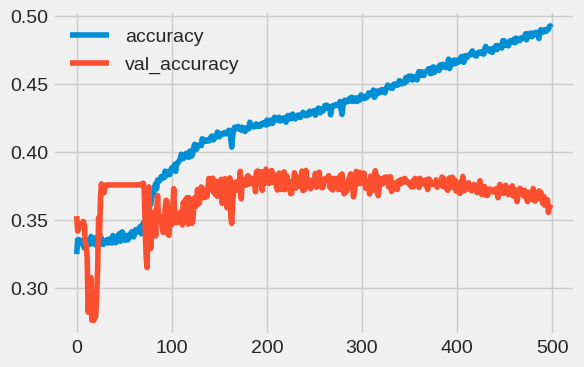

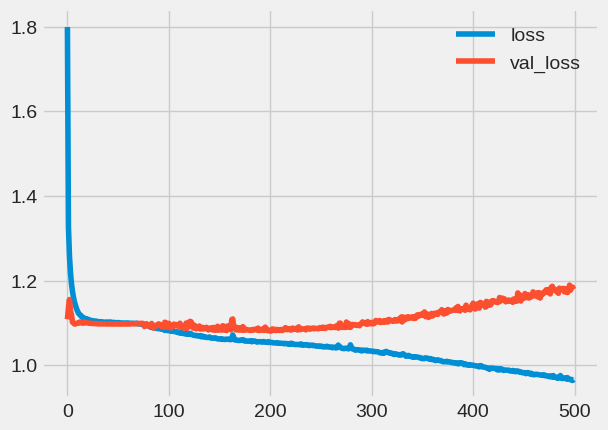

In [18]:
#TCN 1 (39.56%: 2 layer - nb_filters=32)
model = Sequential()

model.add(TCN(nb_filters=64, kernel_size=3, dilations=(1,2,4,8,16,32), input_shape=(trainDataGen[0][0].shape[1], trainDataGen[0][0].shape[2]), padding='same', use_skip_connections=True, dropout_rate=0.2, return_sequences=True, activation='elu', use_batch_norm=False, use_weight_norm=True))
model.add(TCN(nb_filters=32, kernel_size=3, dilations=(1,2,4,8,16), padding='same', use_skip_connections=True, dropout_rate=0.3, return_sequences=False, activation='relu', use_batch_norm=False, use_weight_norm=True))

model.add(Dense(trainDataGen[0][1].shape[1], activation='softmax'))


model.summary()

model.compile(optimizer=Adam(learning_rate = 5e-04),
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

checkpoint_filepath = '/content/drive/MyDrive/Neuro/Базы/fx net/fx models/right_data_tcn_500ep_xBatch_5000_xLen_200_github'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# fit model
history = model.fit(trainDataGen, epochs=500, callbacks=[model_checkpoint_callback], verbose = 1,
                    validation_data=testDataGen)

print('Best result for gold trend forecast is: ', model_checkpoint_callback.best)   #show the best result
model.load_weights(checkpoint_filepath) #upload best weights to the model

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

check our model on testing selection for gold

In [19]:
#take from valDataGen x_val and y_val6
x_val_list = []
y_val_list = []
for i in range(len(valDataGen)):
  x_val = valDataGen[i][0]
  y_val = valDataGen[i][1]
  x_val_list.append(x_val)
  y_val_list.append(y_val)

true_answer = 0
for i in range(len(x_val_list)):   # choose example
  x = x_val_list[i]
  #x = np.expand_dims(x, axis=0)
  prediction = model.predict(x) # identify our example
  #print('\n',prediction)
  prediction = np.argmax(prediction) # get index of best element

  if prediction == np.argmax(y_val_list[i]):
    true_answer+=1
  
  print('Index:', i, '\tPrediction:', prediction, 'Real:', np.argmax(y_val_list[i]),
        '\t====>', y_val_list[i])

#clear_output()

print('Right answers:', true_answer)
print('Wrong answers:', len(x_val_list) - true_answer)
print('Result on testing selection:',(true_answer/(len(x_val_list))*100),'%')

Index: 0 	Prediction: 2 Real: 0 	====> [[1. 0. 0.]]
Index: 1 	Prediction: 2 Real: 2 	====> [[0. 0. 1.]]
Index: 2 	Prediction: 2 Real: 1 	====> [[0. 1. 0.]]
Index: 3 	Prediction: 2 Real: 0 	====> [[1. 0. 0.]]
Index: 4 	Prediction: 1 Real: 1 	====> [[0. 1. 0.]]
Index: 5 	Prediction: 2 Real: 2 	====> [[0. 0. 1.]]
Index: 6 	Prediction: 0 Real: 2 	====> [[0. 0. 1.]]
Index: 7 	Prediction: 2 Real: 2 	====> [[0. 0. 1.]]
Index: 8 	Prediction: 2 Real: 0 	====> [[1. 0. 0.]]
Index: 9 	Prediction: 2 Real: 1 	====> [[0. 1. 0.]]
Index: 10 	Prediction: 2 Real: 0 	====> [[1. 0. 0.]]
Index: 11 	Prediction: 2 Real: 2 	====> [[0. 0. 1.]]
Index: 12 	Prediction: 2 Real: 1 	====> [[0. 1. 0.]]
Index: 13 	Prediction: 1 Real: 1 	====> [[0. 1. 0.]]
Index: 14 	Prediction: 1 Real: 1 	====> [[0. 1. 0.]]
Index: 15 	Prediction: 1 Real: 1 	====> [[0. 1. 0.]]
Index: 16 	Prediction: 1 Real: 2 	====> [[0. 0. 1.]]
Index: 17 	Prediction: 1 Real: 1 	====> [[0. 1. 0.]]
Index: 18 	Prediction: 1 Real: 0 	====> [[1. 0. 0.]]
Ind

In [18]:
#TCN for load weights
model = Sequential()

model.add(TCN(nb_filters=64, kernel_size=3, dilations=(1,2,4,8,16,32), input_shape=(trainDataGen[0][0].shape[1], trainDataGen[0][0].shape[2]), padding='same', use_skip_connections=True, dropout_rate=0.2, return_sequences=True, activation='elu', use_batch_norm=False, use_weight_norm=True))
model.add(TCN(nb_filters=32, kernel_size=3, dilations=(1,2,4,8,16), padding='same', use_skip_connections=True, dropout_rate=0.3, return_sequences=False, activation='relu', use_batch_norm=False, use_weight_norm=True))

model.add(Dense(trainDataGen[0][1].shape[1], activation='softmax'))


model.summary()


checkpoint_filepath = '/content/drive/MyDrive/Neuro/Базы/fx net/fx models/right_data_tcn_500ep_xBatch_5000_xLen_200_github'

model.load_weights(checkpoint_filepath) #upload best weights to the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 200, 64)           293772    
                                                                 
 tcn_1 (TCN)                 (None, 32)                70634     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 364,505
Trainable params: 185,411
Non-trainable params: 179,094
_________________________________________________________________


prepare btc selection for forecast

In [48]:
newdf = data2.copy()

In [49]:
col = newdf.columns #get columns names
print(col) #Выводим
#We go through the indexes of the array with column names 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME', 
#get pairs 'OPEN' & 'MAX', 'OPEN'&'MIN', 'OPEN'&'CLOSE' ..., 'MAX'&'MIN', 'MAX'&'CLOSE'&т.д
for i in range(col.shape[0]):                                                   #for all 
  for j in range(i + 1 , col.shape[0]):                                         #count
    newdf[col[i] + '-' + col[j]] = newdf[col[i]] - newdf[col[j]]                   #difference
    newdf['|' + col[i] + '-' + col[j] + '|'] = abs(newdf[col[i]] - newdf[col[j]])  #the modules of difference
    newdf[col[i] + '*' + col[j]] = newdf[col[i]] * newdf[col[j]]                   #multiply

#for every column 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME':
for i in col:
  newdf['reverse ' + i] = 1 / (newdf[i] + 1e-3)
  newdf['derivative ' + i] = np.nan 
  newdf['derivative ' + i][1:] = newdf[i][1:].reset_index(drop=True) - newdf[i][:-1].reset_index(drop=True)
  newdf['second derivative ' + i] = np.nan 
  newdf['second derivative ' + i][2:] = newdf[i][2:].reset_index(drop=True) - 2 * newdf[i][1:-1].reset_index(drop=True) + newdf[i][:-2].reset_index(drop=True) 

newdf = newdf.drop(columns=['Open-Volume','|Open-Volume|','Open*Volume','High-Volume','|High-Volume|','High*Volume','Low-Volume','|Low-Volume|','Low*Volume','Close-Volume','|Close-Volume|','Close*Volume'])

#add to dataframe relative price change Close, % (for identify trend and delete after)
newdf['deltapercentage'] = newdf['Close'].diff(periods=-1)*100/newdf['Close']
newdf['distance'] = abs(newdf['Close'].diff(periods=-1))
newdf['delta'] = newdf['Close'].diff(periods=-1)
newdf = newdf.iloc[3:-1]
newdf.head()

#add trend (0,1,2)
distancefortrend = 0.145 #0.05 for btc 1h for almost 33% selection for each direction
newdf['Trend'] = newdf['deltapercentage']
newdf.loc[(newdf["deltapercentage"] > -distancefortrend) & (newdf["deltapercentage"] < distancefortrend), "Trend"] = 1 #no trend
newdf.loc[newdf['deltapercentage'] >= distancefortrend, 'Trend'] = 0 #down
newdf.loc[newdf['deltapercentage'] <= -distancefortrend, 'Trend'] = 2 #up
newdf.head(-1)

#check our splitting for uniformity
print('the price was rising',(newdf['Trend'] == 2).sum(),'periods')
print('the price has not changed relatively',(newdf['Trend'] == 1).sum(),'periods')
print('the price was falling:',(newdf['Trend'] == 0).sum(),'periods')

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
the price was rising 29274 periods
the price has not changed relatively 26295 periods
the price was falling: 26899 periods


In [50]:
newdf.head()

,Open,High,Low,Close,Volume,Open-High,|Open-High|,Open*High,Open-Low,|Open-Low|,Open*Low,Open-Close,|Open-Close|,Open*Close,High-Low,|High-Low|,High*Low,High-Close,|High-Close|,High*Close,Low-Close,|Low-Close|,Low*Close,reverse Open,derivative Open,second derivative Open,reverse High,derivative High,second derivative High,reverse Low,derivative Low,second derivative Low,reverse Close,derivative Close,second derivative Close,reverse Volume,derivative Volume,second derivative Volume,deltapercentage,distance,delta,Trend
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-12-31 11:00:00,4.39,4.39,4.39,4.39,27.334852,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.036582,0.000000,0.000000,0.000000,0.00,0.00,1.0
2011-12-31 12:00:00,4.39,4.39,4.39,4.39,27.334852,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.036582,0.000000,0.000000,0.000000,0.00,0.00,1.0
2011-12-31 13:00:00,4.39,4.39,4.39,4.39,27.334852,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.036582,0.000000,0.000000,0.000000,0.00,0.00,1.0
2011-12-31 14:00:00,4.39,4.39,4.39,4.39,27.334852,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.036582,0.000000,0.000000,0.000000,0.00,0.00,1.0
2011-12-31 15:00:00,4.39,4.39,4.39,4.39,502.779044,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.0,0.0,19.2721,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.001989,475.444191,475.444191,-4.100228,0.18,-0.18,2.0


In [51]:
#identify japanese candles and patterns
for i in range(2,newdf.shape[0]):
  current = newdf.iloc[i,:]
  prev = newdf.iloc[i-1,:]
  prev_2 = newdf.iloc[i-2,:]
  realbody = abs(current['Open'] - current['Close'])
  candle_range = current['High'] - current['Low']
  idx = newdf.index[i]

  # Bullish swing
  newdf.loc[idx,'Bullish swing'] = current['Low'] > prev['Low'] and prev['Low'] < prev_2['Low']
  # Bearish swing
  newdf.loc[idx,'Bearish swing'] = current['High'] < prev['High'] and prev['High'] > prev_2['High']
  # Bullish pinbar
  newdf.loc[idx,'Bullish pinbar'] = realbody <= candle_range/3 and  min(current['Open'], current['Close']) > (current['High'] + current['Low'])/2 and current['Low'] < prev['Low']
  # Bearish pinbar
  newdf.loc[idx,'Bearish pinbar'] = realbody <= candle_range/3 and max(current['Open'] , current['Close']) < (current['High'] + current['Low'])/2 and current['High'] > prev['High']
    
  # Inside bar
  newdf.loc[idx,'Inside bar'] = current['High'] < prev['High'] and current['Low'] > prev['Low']
    
  # Outside bar
  newdf.loc[idx,'Outside bar'] = current['High'] > prev['High'] and current['Low'] < prev['Low']
  
  # Bullish engulfing
  newdf.loc[idx,'Bullish engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] > current['Open']
  # Bearish engulfing
  newdf.loc[idx,'Bearish engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] < current['Open']

newdf.fillna(False, inplace=True)

#change boolean to int
u = newdf.select_dtypes(bool)
newdf[u.columns] = u.astype(int)
newdf.head(-10)

,Open,High,Low,Close,Volume,Open-High,|Open-High|,Open*High,Open-Low,|Open-Low|,Open*Low,Open-Close,|Open-Close|,Open*Close,High-Low,|High-Low|,High*Low,High-Close,|High-Close|,High*Close,Low-Close,|Low-Close|,Low*Close,reverse Open,derivative Open,second derivative Open,reverse High,derivative High,second derivative High,reverse Low,derivative Low,second derivative Low,reverse Close,derivative Close,second derivative Close,reverse Volume,derivative Volume,second derivative Volume,deltapercentage,distance,delta,Trend,Bullish swing,Bearish swing,Bullish pinbar,Bearish pinbar,Inside bar,Outside bar,Bullish engulfing,Bearish engulfing
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-12-31 11:00:00,4.39,4.39,4.39,4.39,27.334852,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.036582,0.000000,0.000000,0.000000,0.00,0.00,1.0,0,0,0,0,0,0,0,0
2011-12-31 12:00:00,4.39,4.39,4.39,4.39,27.334852,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.036582,0.000000,0.000000,0.000000,0.00,0.00,1.0,0,0,0,0,0,0,0,0
2011-12-31 13:00:00,4.39,4.39,4.39,4.39,27.334852,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.036582,0.000000,0.000000,0.000000,0.00,0.00,1.0,0,0,0,0,0,0,0,0
2011-12-31 14:00:00,4.39,4.39,4.39,4.39,27.334852,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.036582,0.000000,0.000000,0.000000,0.00,0.00,1.0,0,0,0,0,0,0,0,0
2011-12-31 15:00:00,4.39,4.39,4.39,4.39,502.779044,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.0,0.0,1.927210e+01,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.227739,0.0,0.0,0.001989,475.444191,475.444191,-4.100228,0.18,-0.18,2.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-02 08:00:00,37214.20,37450.00,37080.20,37396.10,84.390313,-235.8,235.8,1.393672e+09,134.0,134.0,1.379910e+09,-181.9,181.9,1.391666e+09,369.8,369.8,1.388653e+09,53.9,53.9,1.400484e+09,-315.9,315.9,1.386655e+09,0.000027,464.1,544.0,0.000027,67.6,-321.7,0.000027,330.1,265.5,0.000027,181.8,-280.7,0.011850,-432.465109,-853.700537,0.307251,114.90,114.90,0.0,0,0,0,0,0,0,0,0
2021-06-02 09:00:00,37396.20,37496.20,37181.20,37281.20,98.237993,-100.0,100.0,1.402215e+09,215.0,215.0,1.390436e+09,115.0,115.0,1.394175e+09,315.0,315.0,1.394154e+09,215.0,215.0,1.397903e+09,-100.0,100.0,1.386160e+09,0.000027,182.0,-282.1,0.000027,46.2,-21.4,0.000027,101.0,-229.1,0.000027,-114.9,-296.7,0.010179,13.847680,446.312789,0.327511,122.10,122.10,0.0,0,0,0,0,0,0,0,0
2021-06-02 10:00:00,37273.20,37287.30,37041.60,37159.10,164.529042,-14.1,14.1,1.389817e+09,231.6,231.6,1.380659e+09,114.1,114.1,1.385039e+09,245.7,245.7,1.381181e+09,128.2,128.2,1.385563e+09,-117.5,117.5,1.376433e+09,0.000027,-123.0,-305.0,0.000027,-208.9,-255.1,0.000027,-139.6,-240.6,0.000027,-122.1,-7.2,0.006078,66.291048,52.443368,-0.113027,42.00,-42.00,1.0,0,1,0,0,0,0,0,0


In [52]:
#add days of the week: 1=Monday, 7=Sunday
newdf['year'] = pd.DatetimeIndex(newdf.index).year
newdf['month'] = pd.DatetimeIndex(newdf.index).month
newdf['day'] = pd.DatetimeIndex(newdf.index).day

DayinWeek = []
for i in range(newdf.shape[0]):  
  DayinWeek.append(date(newdf['year'][i], newdf['month'][i], newdf['day'][i]).isoweekday())
newdf['WeekDay'] = DayinWeek
newdf = newdf.drop(columns=['year','month','day','deltapercentage', 'distance', 'delta']) #delete useless columns

#prepare our df to normalization
for i in list(newdf.columns):
  newdf[i] = newdf[i].astype(float)

In [53]:
#data normalization
indicator_name = 'Trend'
data_Y = newdf['Trend']

categorical_labels = to_categorical(data_Y, num_classes = 3)
print(len(categorical_labels))
print(categorical_labels[:5])

data = newdf.drop(columns=['Trend']) #delete right answers from xTrain

data = data.values
print(data.shape, type(data))

#split data for studing, chwcking and testing selections
n_train = 5000
n_val = 1000
xTrain = data[:-(n_train+n_val)]
xTest = data[-(n_train+n_val):-n_val]
xVal = data[-n_val:]
yTrain = categorical_labels[:-(n_train+n_val)]
yTest = categorical_labels[-(n_train+n_val):-n_val]
yVal = categorical_labels[-n_val:]

print('xTrain: ', xTrain.shape, '\tyTrain:', yTrain.shape,
      '\nxTest:  ', xTest.shape, '\tyTest: ', yTest.shape,
      '\nxVal:  ', xVal.shape, '\tyVal: ', yVal.shape)
xTrain.shape[0]+xTest.shape[0]+xVal.shape[0]

#normalize our data with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
""" 
# Scaling only X
"""
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)
xVal = xScaler.transform(xVal)

print(xTrain.shape, xTest.shape, type(xTrain))
xTest[-1:]

82468
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(82468, 47) <class 'numpy.ndarray'>
xTrain:  (76468, 47) 	yTrain: (76468, 3) 
xTest:   (5000, 47) 	yTest:  (5000, 3) 
xVal:   (1000, 47) 	yVal:  (1000, 3)
(76468, 47) (5000, 47) <class 'numpy.ndarray'>


array([[ 2.78812797e+00,  2.79074888e+00,  2.80465752e+00,
         2.78854245e+00,  2.99396685e-03,  7.85530583e-01,
         2.14469417e-01,  7.77884985e+00,  3.57966161e-02,
         3.57966161e-02,  7.83759973e+00,  4.42493588e-01,
         5.76553491e-03,  7.79351798e+00,  1.16475000e-01,
         1.16475000e-01,  7.84496548e+00,  2.16613787e-01,
         2.16613787e-01,  7.79520110e+00,  9.60114714e-01,
         3.98852857e-02,  7.81945538e+00, -1.35885359e-04,
         5.20542475e-01,  3.03115969e-01, -1.36112237e-04,
         5.20782119e-01,  3.44116245e-01, -4.97852561e-05,
         5.46617483e-01,  3.21780200e-01, -1.35896655e-04,
         5.09794747e-01,  3.25822736e-01,  6.90703871e-06,
         4.96945724e-01,  6.65811408e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.00000000e-01]])

GET RESULT OF FORECAST TO BTC BY NEURAL NET FOR GOLD

In [55]:
#prepare for TCN
xTrain1 = xTrain.copy()
xTest1 = xTest.copy()
xVal1 = xVal.copy()
yTrain1 = yTrain.copy()
yTest1 = yTest.copy()
yVal1 = yVal.copy()
print(xTrain.shape)
print(yTrain.shape)

# Creating a generator for training
trainDataGen = TimeseriesGenerator(xTrain1, yTrain1, length=xLen, sampling_rate=1, stride=1, batch_size=xBatch)

#Creating a similar generator for validation during training
testDataGen = TimeseriesGenerator(xTest1, yTest1, length=xLen, stride=1, batch_size=xBatch)

#Creating a generator for the test
valDataGen = TimeseriesGenerator(xVal1, yVal1, length=xLen, stride=1, batch_size=1)

(76468, 47)
(76468, 3)


In [56]:
#take from valDataGen x_val and y_val6
x_val_list = []
y_val_list = []
for i in range(len(valDataGen)):
  x_val = valDataGen[i][0]
  y_val = valDataGen[i][1]
  x_val_list.append(x_val)
  y_val_list.append(y_val)

true_answer = 0
for i in range(len(x_val_list)):   # choose example
  x = x_val_list[i]
  #x = np.expand_dims(x, axis=0)
  prediction = model.predict(x) # identify our example
  #print('\n',prediction)
  prediction = np.argmax(prediction) # get index of best element

  if prediction == np.argmax(y_val_list[i]):
    true_answer+=1
  
  print('Index:', i, '\tPrediction:', prediction, 'Real:', np.argmax(y_val_list[i]),
        '\t====>', y_val_list[i])

#clear_output()

print('Right answers:', true_answer)
print('Wrong answers:', len(x_val_list) - true_answer)
print('Result on testing selection:',(true_answer/(len(x_val_list))*100),'%')

Index: 0 	Prediction: 2 Real: 0 	====> [[1. 0. 0.]]
Index: 1 	Prediction: 2 Real: 0 	====> [[1. 0. 0.]]
Index: 2 	Prediction: 2 Real: 2 	====> [[0. 0. 1.]]
Index: 3 	Prediction: 2 Real: 2 	====> [[0. 0. 1.]]
Index: 4 	Prediction: 2 Real: 0 	====> [[1. 0. 0.]]
Index: 5 	Prediction: 2 Real: 2 	====> [[0. 0. 1.]]
Index: 6 	Prediction: 2 Real: 2 	====> [[0. 0. 1.]]
Index: 7 	Prediction: 2 Real: 2 	====> [[0. 0. 1.]]
Index: 8 	Prediction: 2 Real: 2 	====> [[0. 0. 1.]]
Index: 9 	Prediction: 2 Real: 2 	====> [[0. 0. 1.]]
Index: 10 	Prediction: 2 Real: 0 	====> [[1. 0. 0.]]
Index: 11 	Prediction: 2 Real: 1 	====> [[0. 1. 0.]]
Index: 12 	Prediction: 2 Real: 0 	====> [[1. 0. 0.]]
Index: 13 	Prediction: 2 Real: 1 	====> [[0. 1. 0.]]
Index: 14 	Prediction: 2 Real: 0 	====> [[1. 0. 0.]]
Index: 15 	Prediction: 2 Real: 0 	====> [[1. 0. 0.]]
Index: 16 	Prediction: 2 Real: 0 	====> [[1. 0. 0.]]
Index: 17 	Prediction: 2 Real: 1 	====> [[0. 1. 0.]]
Index: 18 	Prediction: 2 Real: 0 	====> [[1. 0. 0.]]
Ind